# Music genre classification

## Table of contents

* [Introduction and project description](#Introduction-and-project-description)
* [Imports](#Imports)
* [Data exploration](#Data-exploration)
* Data augmentation
* Model training
* Results
* Future works

## Introduction and project description

## Imports

## Data exploration

#### XXX Removing the one corrupted file?

## Data augmentation

#### XXX Pitch shift, time stretch and noise addition

#### XXX Adding reverb?

## Model training

#### XXX Focal loss

https://arxiv.org/pdf/1708.02002.pdf

#### XXX Sacred for experiment tracking

#### XXX Doing on the fly augmentations

#### XXX Loss curves

## Results

#### XXX Model evaluation

## Deployment

## Future works

[Back to top](#Table-of-contents)

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
# Misc
import os, sys
from glob import glob

In [5]:
import random

In [6]:
# Dataframes and such
import pandas as pd
import numpy as np

In [7]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Ipython stuff
import IPython
import IPython.display as ipd

In [9]:
# Audio stuff
import librosa
import librosa.display

In [15]:
from tqdm.notebook import tqdm

In [10]:
DATA_FOLDER = "../data/gtzan"

## Sample audio files

In [11]:
# Had to remove jazz file #54 because of corruption, apparently

[Back to top](#Table-of-contents)

In [12]:
# Make a list of all the wav files in the dataset and store them in a variable
audio_files = glob(f"{DATA_FOLDER}/*/*.wav")

In [11]:
random_file = random.choice(audio_files)
print(f"Showing random file {os.path.basename(random_file)}")
ipd.Audio(random_file)

Showing random file classical.00002.wav


In [12]:
# Load audio file with librosa
y, sr = librosa.load(random_file)

print(f"y is a {type(y)}, sr is a {type(sr)}")
print(f"First 10 elements of y: {y[:10]}")
print(f"Shape of Y: {y.shape}")
print(f"Sample Rate: {sr}")

y is a <class 'numpy.ndarray'>, sr is a <class 'int'>
First 10 elements of y: [-0.04046631 -0.07815552 -0.08737183 -0.09909058 -0.10864258 -0.10696411
 -0.08862305 -0.07034302 -0.06018066 -0.03759766]
Shape of Y: (661794,)
Sample Rate: 22050


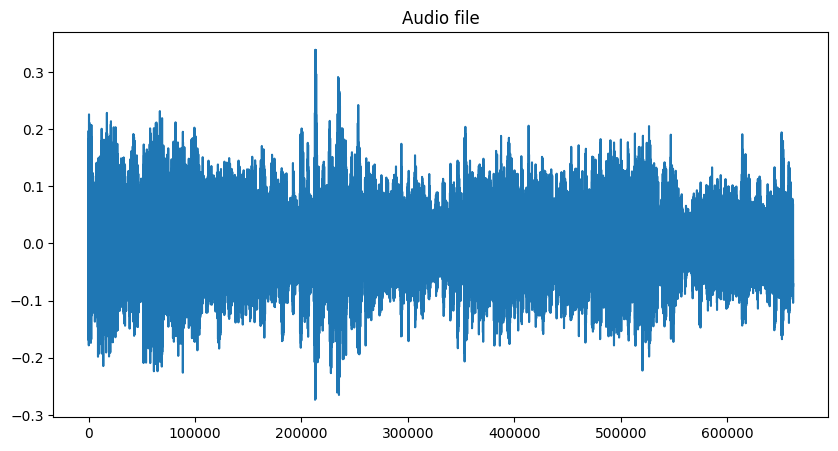

In [13]:
# Plot the actual wave
plt.figure(figsize=(16, 8))
pd.Series(y).plot(figsize=(10, 5), title="Audio file");

### MEL Spectrograms

In [95]:
# apply mel spectogram without STFT

hop_length = 512

n_fft = 2048
n_mels = 512

In [96]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length)
print("Shape of Mel Spectogram", S.shape)

# use that converting function as above
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

Shape of Mel Spectogram (512, 1293)


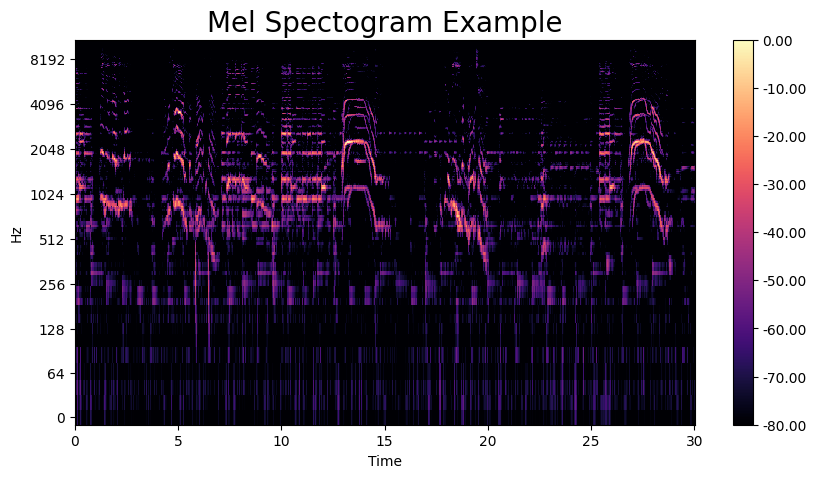

In [94]:
# plot the mel spectogram
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_mel, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f');

## Dataset creation

In [15]:
OUT_FOLDER = "../data/gtzan_processed"

In [18]:
processed_files = {
    'path': [],
    'genre': [],
}

for af in tqdm(audio_files):
    af_arr = af.split('/')
    genre = af_arr[-2]
    fname = af_arr[-1]
    
    genre_folder = f"{OUT_FOLDER}/{genre}"
    
    os.makedirs(genre_folder, exist_ok=True)
    
    # Load audio file and create spectrogram
    y, sr = librosa.load(af)
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length)
    
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    
    out_file = f"{genre_folder}/{fname[:-4]}.npy"
    
    processed_files['path'].append(out_file)
    processed_files['genre'].append(genre)
    
    np.save(out_file, S_db_mel)

  0%|          | 0/999 [00:00<?, ?it/s]

In [19]:
S_db_mel.shape

(256, 1293)

In [20]:
df = pd.DataFrame(processed_files)

In [21]:
# Just save relative path in the dataframe
df['path'] = df['path'].apply(lambda x: x[8+15+1:])

In [22]:
df.head()

,path,genre
0,metal/metal.00000.npy,metal
1,metal/metal.00032.npy,metal
2,metal/metal.00034.npy,metal
3,metal/metal.00063.npy,metal
4,metal/metal.00090.npy,metal


### Train/test split

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['genre'])

In [25]:
df_train['subset'] = 'train'
df_test['subset'] = 'test'

In [26]:
df_full = pd.concat((df_train, df_test)).sample(frac=1.0) # frac is to shuffle

In [27]:
df_full.head(n=10)

,path,genre,subset
28,metal/metal.00076.npy,metal,test
615,pop/pop.00016.npy,pop,test
152,reggae/reggae.00036.npy,reggae,test
285,jazz/jazz.00018.npy,jazz,train
714,classical/classical.00022.npy,classical,test
98,metal/metal.00041.npy,metal,train
654,pop/pop.00087.npy,pop,train
673,pop/pop.00051.npy,pop,test
306,rock/rock.00060.npy,rock,train
523,blues/blues.00065.npy,blues,train


In [28]:
df_full.to_csv(f"{OUT_FOLDER}/metadata.csv", index=False)

### Wav dataset

In [13]:
OUT_FOLDER = "../data/gtzan"

In [17]:
wav_files = {
    'path': [],
    'genre': [],
}

for af in tqdm(audio_files):
    af_arr = af.split('/')
    genre = af_arr[-2]
    fname = af_arr[-1]
    
    out_file = f"{genre}/{fname}"
    
    wav_files['path'].append(out_file)
    wav_files['genre'].append(genre)
    
df = pd.DataFrame(wav_files)

  0%|          | 0/999 [00:00<?, ?it/s]

In [20]:
df = pd.DataFrame(wav_files)

In [21]:
df.head()

,path,genre
0,metal/metal.00000.wav,metal
1,metal/metal.00032.wav,metal
2,metal/metal.00034.wav,metal
3,metal/metal.00063.wav,metal
4,metal/metal.00090.wav,metal


### Train/test split

In [22]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['genre'])

df_train['subset'] = 'train'
df_test['subset'] = 'test'

df_full = pd.concat((df_train, df_test)).sample(frac=1.0) # frac is to shuffle

df_full.head(n=10)

In [23]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['genre'])

In [24]:
df_train['subset'] = 'train'
df_test['subset'] = 'test'

In [25]:
df_full = pd.concat((df_train, df_test)).sample(frac=1.0) # frac is to shuffle

In [26]:
df_full.head(n=10)

,path,genre,subset
995,hiphop/hiphop.00070.wav,hiphop,train
323,rock/rock.00044.wav,rock,train
387,rock/rock.00069.wav,rock,train
90,metal/metal.00084.wav,metal,train
30,metal/metal.00071.wav,metal,test
113,reggae/reggae.00005.wav,reggae,test
787,classical/classical.00010.wav,classical,train
155,reggae/reggae.00099.wav,reggae,train
104,reggae/reggae.00084.wav,reggae,train
939,hiphop/hiphop.00085.wav,hiphop,train


In [27]:
df_full.to_csv(f"{OUT_FOLDER}/metadata_t20.csv", index=False)